# 03 - Logistic Regression Baseline

## Diabetic Foot Ulcer Risk Classification - Baseline Model

This notebook trains a Logistic Regression classifier as a baseline for comparison with the Random Forest model.

### Objectives:
- Preprocess data with the same feature engineering as RF
- Train Logistic Regression classifier
- Evaluate and compare with Random Forest
- Export model as .pkl and .tflite for mobile deployment

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 1. Load Dataset

In [2]:
# Load the dataset
DATA_PATH = '../Synthetic_Data/synthetic_foot_ulcer_dataset_RISK.csv'
df = pd.read_csv(DATA_PATH)

print(f" Dataset loaded: {df.shape[0]} samples × {df.shape[1]} columns")
df.head()

 Dataset loaded: 10000 samples × 20 columns


,temp_heel,press_heel,temp_ball,press_ball,temp_arch,press_arch,temp_toe,press_toe,spo2,heartRate,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,stepCount,batteryLevel,risk_score,label
0,33.498160,58.028572,34.927976,43.946339,32.624075,26.239781,32.232334,54.647046,95.621089,81,0.239495,-0.478550,9.866665,-34.223433,-42.545393,-9.398040,59,99,0.378454,0
1,32.931085,23.624257,34.473544,35.298480,35.932924,38.670516,35.439762,47.212302,85.198974,119,-6.080159,3.358271,12.137578,-88.087821,90.418256,29.849513,34,97,0.693139,1
2,33.564242,27.289444,35.021446,37.006235,32.831767,42.708013,32.125253,53.691391,90.927254,73,-2.721560,3.565877,12.156596,212.480807,21.078883,131.341689,23,45,0.555218,0
3,35.861021,44.281370,33.103997,31.850940,40.354115,105.342867,33.693606,35.795261,95.935108,92,2.095321,0.520806,11.786854,19.289773,-13.456407,93.181492,32,67,0.662824,1
4,33.483273,46.753650,34.663689,43.651912,33.098887,42.449737,33.531707,58.868484,95.825943,73,10.116889,-2.761172,8.604085,-4.869127,-113.500037,83.399329,95,23,0.388919,0


## 2. Feature Definition

Using the same features as the Random Forest model for fair comparison.

### Features to INCLUDE:
- Temperature sensors (4): temp_heel, temp_ball, temp_arch, temp_toe
- Pressure sensors (4): press_heel, press_ball, press_arch, press_toe
- Vital signs (2): spo2, heartRate
- Motion sensors (6): acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z
- Activity (1): stepCount

### Features to EXCLUDE:
- `batteryLevel`: System-level feature
- `risk_score`: Model output, NOT input

In [3]:
# Define feature groups (same as Random Forest)
TEMP_FEATURES = ['temp_heel', 'temp_ball', 'temp_arch', 'temp_toe']
PRESSURE_FEATURES = ['press_heel', 'press_ball', 'press_arch', 'press_toe']
VITAL_FEATURES = ['spo2', 'heartRate']
ACC_FEATURES = ['acc_x', 'acc_y', 'acc_z']
GYRO_FEATURES = ['gyro_x', 'gyro_y', 'gyro_z']
ACTIVITY_FEATURES = ['stepCount']

# All raw sensor features
RAW_SENSOR_FEATURES = (TEMP_FEATURES + PRESSURE_FEATURES + VITAL_FEATURES + 
                       ACC_FEATURES + GYRO_FEATURES + ACTIVITY_FEATURES)

# Target column
TARGET = 'label'

print(f"Raw sensor features ({len(RAW_SENSOR_FEATURES)}): {RAW_SENSOR_FEATURES}")

Raw sensor features (17): ['temp_heel', 'temp_ball', 'temp_arch', 'temp_toe', 'press_heel', 'press_ball', 'press_arch', 'press_toe', 'spo2', 'heartRate', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'stepCount']


## 3. Feature Engineering

Same engineered features as Random Forest for consistent comparison.

In [4]:
# Create a copy for feature engineering
df_processed = df.copy()

# =============================================================================
# ENGINEERED FEATURES (same as Random Forest)
# =============================================================================

# Pressure features
df_processed['max_pressure'] = df_processed[PRESSURE_FEATURES].max(axis=1)
df_processed['pressure_variance'] = df_processed[PRESSURE_FEATURES].var(axis=1)

# Temperature features
df_processed['max_temp'] = df_processed[TEMP_FEATURES].max(axis=1)
df_processed['temp_variance'] = df_processed[TEMP_FEATURES].var(axis=1)

# Motion magnitude features
df_processed['acc_magnitude'] = np.sqrt(
    df_processed['acc_x']**2 + 
    df_processed['acc_y']**2 + 
    df_processed['acc_z']**2
)

df_processed['gyro_magnitude'] = np.sqrt(
    df_processed['gyro_x']**2 + 
    df_processed['gyro_y']**2 + 
    df_processed['gyro_z']**2
)

# Define engineered features
ENGINEERED_FEATURES = [
    'max_pressure', 'pressure_variance',
    'max_temp', 'temp_variance',
    'acc_magnitude', 'gyro_magnitude'
]

print(f" Engineered features created: {ENGINEERED_FEATURES}")
df_processed[ENGINEERED_FEATURES].describe()

 Engineered features created: ['max_pressure', 'pressure_variance', 'max_temp', 'temp_variance', 'acc_magnitude', 'gyro_magnitude']


,max_pressure,pressure_variance,max_temp,temp_variance,acc_magnitude,gyro_magnitude
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,64.596223,359.000757,36.376418,3.301407,10.671380,127.558684
std,21.680199,431.893589,1.989464,3.612137,2.822650,53.745618
min,24.814384,0.256188,32.280170,0.002370,1.174682,4.907324
25%,50.888792,92.210175,35.082359,0.899668,8.763291,88.603606
50%,56.688439,175.441829,35.664349,1.729986,10.611316,123.028521
75%,76.954200,417.771393,37.997981,4.628611,12.573150,161.748950
max,119.986875,2236.700968,40.996875,17.289692,21.509454,394.913082


In [5]:
# Combine all features for model
ALL_FEATURES = RAW_SENSOR_FEATURES + ENGINEERED_FEATURES

print(f"\n{'='*80}")
print("FINAL FEATURE SET FOR MODEL TRAINING")
print(f"{'='*80}")
print(f"\nTotal features: {len(ALL_FEATURES)}")


FINAL FEATURE SET FOR MODEL TRAINING

Total features: 23


## 4. Prepare Features and Target

In [6]:
# Separate features (X) and target (y)
X = df_processed[ALL_FEATURES].copy()
y = df_processed[TARGET].copy()

print(f"Feature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())

Feature matrix X shape: (10000, 23)
Target vector y shape: (10000,)

Class distribution:
label
0    6692
1    3308
Name: count, dtype: int64


In [7]:
# Train-test split (80-20) - same random state as RF for fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 8000 samples
Test set: 2000 samples


## 5. Feature Scaling

**CRITICAL for Logistic Regression**: Feature scaling is mandatory for optimal performance.

In [8]:
# Initialize and fit scaler
scaler_lr = StandardScaler()

# Fit on training data only, transform both
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

print(" Features scaled using StandardScaler")
print("\n Note: Scaling is MANDATORY for Logistic Regression!")

 Features scaled using StandardScaler

 Note: Scaling is MANDATORY for Logistic Regression!


## 6. Train Logistic Regression Classifier

In [9]:
# Initialize Logistic Regression with class balancing
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    solver='lbfgs',
    C=1.0
)

# Train the model
print("Training Logistic Regression classifier...")
lr_model.fit(X_train_scaled, y_train)
print(" Model training complete!")

Training Logistic Regression classifier...
 Model training complete!


In [10]:
# Cross-validation score
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS (5-Fold)")
print(f"{'='*80}")
print(f"ROC-AUC scores: {cv_scores}")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


CROSS-VALIDATION RESULTS (5-Fold)
ROC-AUC scores: [0.98585319 0.98936563 0.99002752 0.98650979 0.98579087]
Mean ROC-AUC: 0.9875 (+/- 0.0036)


## 7. Model Evaluation

In [11]:
# Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n{'='*80}")
print("MODEL EVALUATION METRICS")
print(f"{'='*80}")
print(f"\n  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")


MODEL EVALUATION METRICS

  Accuracy:  0.9310
  Precision: 0.8669
  Recall:    0.9350
  F1-Score:  0.8997
  ROC-AUC:   0.9870


In [12]:
# Classification report
print(f"\n{'='*80}")
print("CLASSIFICATION REPORT")
print(f"{'='*80}")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'High Risk (1)']))


CLASSIFICATION REPORT
               precision    recall  f1-score   support

   Normal (0)       0.97      0.93      0.95      1338
High Risk (1)       0.87      0.94      0.90       662

     accuracy                           0.93      2000
    macro avg       0.92      0.93      0.92      2000
 weighted avg       0.93      0.93      0.93      2000



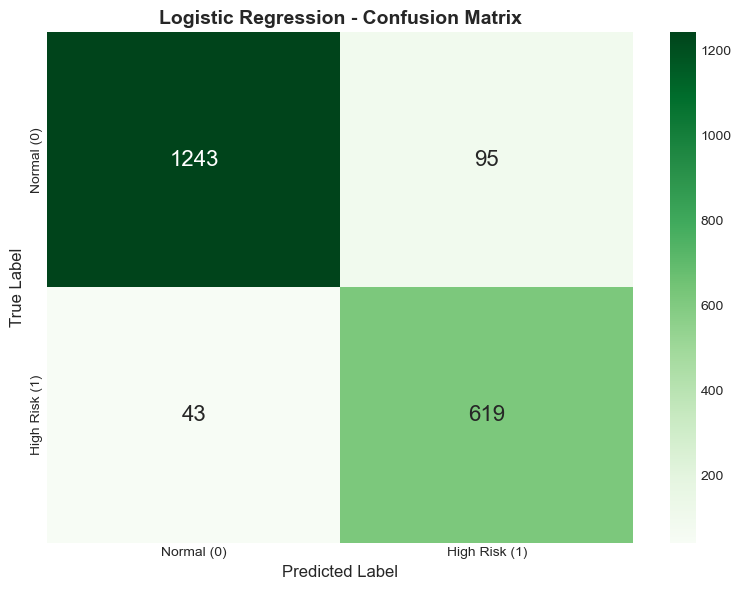

 Plot saved: plots/lr_confusion_matrix.png


In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Normal (0)', 'High Risk (1)'],
            yticklabels=['Normal (0)', 'High Risk (1)'],
            annot_kws={'size': 16}, ax=ax)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/lr_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Plot saved: plots/lr_confusion_matrix.png")

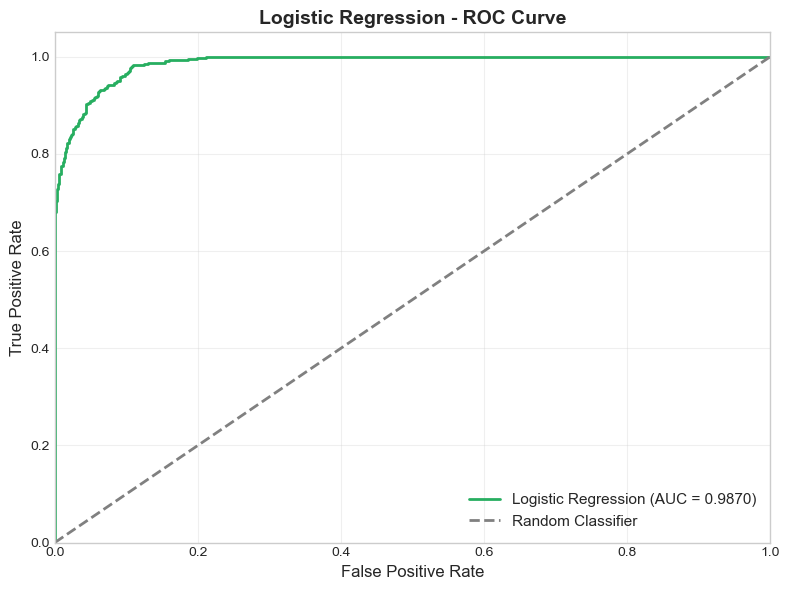

 Plot saved: plots/lr_roc_curve.png


In [14]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='#27ae60', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Logistic Regression - ROC Curve', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/lr_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Plot saved: plots/lr_roc_curve.png")

## 8. Feature Coefficients

In [15]:
# Get feature coefficients
feature_coef = pd.DataFrame({
    'feature': ALL_FEATURES,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print(f"\n{'='*80}")
print("FEATURE COEFFICIENTS (sorted by absolute value)")
print(f"{'='*80}")
print(feature_coef[['feature', 'coefficient']].to_string(index=False))


FEATURE COEFFICIENTS (sorted by absolute value)
          feature  coefficient
             spo2    -5.189481
         max_temp     3.209373
     max_pressure     2.210758
        stepCount    -2.024330
    acc_magnitude     1.698778
        press_toe     0.485001
       press_heel     0.453524
        temp_arch     0.433198
        temp_heel     0.387104
       press_ball     0.366872
        temp_ball     0.350821
       press_arch     0.333131
    temp_variance    -0.316298
pressure_variance    -0.267566
         temp_toe     0.265336
            acc_x    -0.108843
        heartRate     0.089277
           gyro_x     0.070775
           gyro_y    -0.040240
           gyro_z     0.035662
            acc_y    -0.028163
   gyro_magnitude    -0.019896
            acc_z    -0.019706


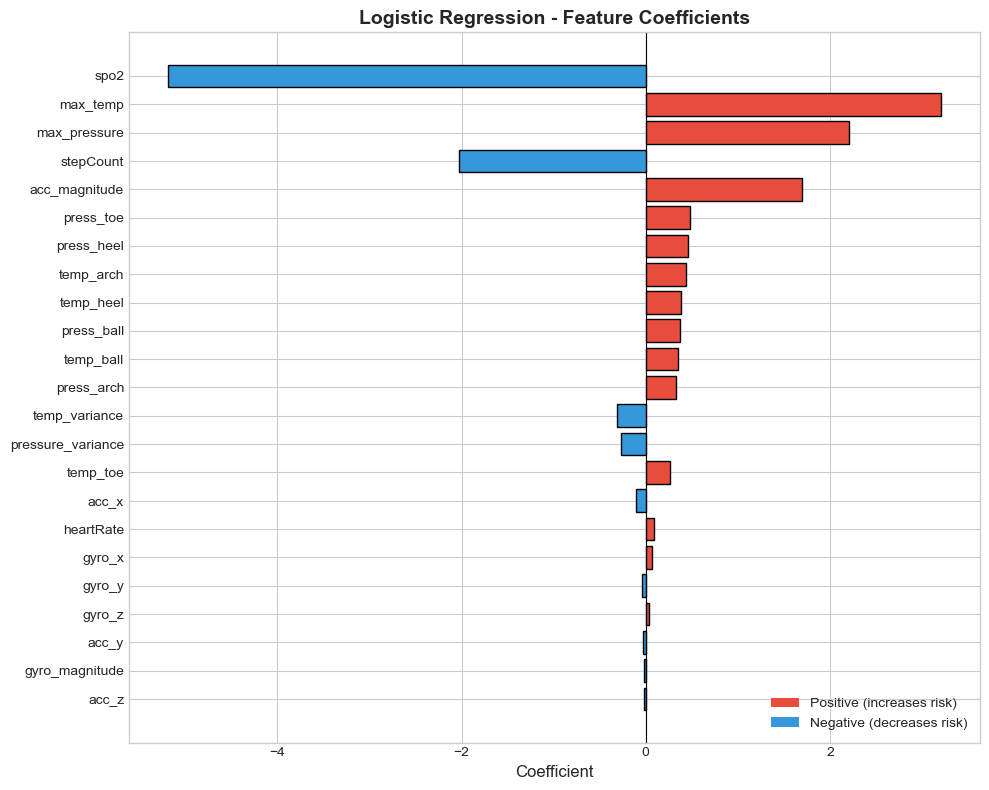

 Plot saved: plots/lr_feature_coefficients.png


In [16]:
# Plot feature coefficients
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c' if x > 0 else '#3498db' for x in feature_coef['coefficient'].values]
bars = ax.barh(feature_coef['feature'], feature_coef['coefficient'], 
               color=colors, edgecolor='black')

ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Coefficient', fontsize=12)
ax.set_title('Logistic Regression - Feature Coefficients', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Positive (increases risk)'),
    Patch(facecolor='#3498db', label='Negative (decreases risk)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('plots/lr_feature_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Plot saved: plots/lr_feature_coefficients.png")

## 9. Save Model (.pkl)

In [17]:
# Save the trained model
LR_MODEL_PATH = 'models/logistic_regression_model.pkl'
joblib.dump(lr_model, LR_MODEL_PATH)
print(f" Model saved: {LR_MODEL_PATH}")

# Save the scaler
SCALER_LR_PATH = 'models/scaler_lr.pkl'
joblib.dump(scaler_lr, SCALER_LR_PATH)
print(f" Scaler saved: {SCALER_LR_PATH}")

 Model saved: models/logistic_regression_model.pkl
 Scaler saved: models/scaler_lr.pkl


## 10. TensorFlow Lite Conversion

In [18]:
# Import TensorFlow
import tensorflow as tf
from tensorflow import keras

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [19]:
# Create a Neural Network equivalent of Logistic Regression
# Logistic Regression = Single layer NN with sigmoid activation

lr_nn_model = keras.Sequential([
    keras.layers.Input(shape=(len(ALL_FEATURES),)),
    keras.layers.Dense(1, activation='sigmoid', 
                       kernel_initializer=keras.initializers.Constant(lr_model.coef_.T),
                       bias_initializer=keras.initializers.Constant(lr_model.intercept_))
])

lr_nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

lr_nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Verify NN model matches sklearn LR
nn_pred_proba = lr_nn_model.predict(X_test_scaled, verbose=0).flatten()
nn_pred = (nn_pred_proba >= 0.5).astype(int)

nn_accuracy = accuracy_score(y_test, nn_pred)
nn_roc_auc = roc_auc_score(y_test, nn_pred_proba)

print(f"\n{'='*80}")
print("NEURAL NETWORK EQUIVALENT VERIFICATION")
print(f"{'='*80}")
print(f"\n  sklearn LR Accuracy:  {accuracy:.4f}")
print(f"  keras NN Accuracy:    {nn_accuracy:.4f}")
print(f"\n  sklearn LR ROC-AUC:   {roc_auc:.4f}")
print(f"  keras NN ROC-AUC:     {nn_roc_auc:.4f}")

# Check prediction correlation
pred_correlation = np.corrcoef(y_pred_proba, nn_pred_proba)[0, 1]
print(f"\n  Prediction correlation: {pred_correlation:.6f}")

if pred_correlation > 0.99:
    print("\n Neural network successfully replicates Logistic Regression!")


NEURAL NETWORK EQUIVALENT VERIFICATION

  sklearn LR Accuracy:  0.9310
  keras NN Accuracy:    0.9310

  sklearn LR ROC-AUC:   0.9870
  keras NN ROC-AUC:     0.9870

  Prediction correlation: 1.000000

 Neural network successfully replicates Logistic Regression!


In [21]:
# Save the Keras model
LR_KERAS_PATH = 'models/lr_neural_network.keras'
lr_nn_model.save(LR_KERAS_PATH)
print(f" Keras model saved: {LR_KERAS_PATH}")

 Keras model saved: models/lr_neural_network.keras


In [22]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(lr_nn_model)

# Optimization for mobile
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Convert
tflite_model = converter.convert()

# Save TFLite model
LR_TFLITE_PATH = 'models/logistic_regression_model.tflite'
with open(LR_TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f" TFLite model saved: {LR_TFLITE_PATH}")
print(f"   Model size: {len(tflite_model) / 1024:.2f} KB")

INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmp9w_9a0mq\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmp9w_9a0mq\assets


Saved artifact at 'C:\Users\HP\AppData\Local\Temp\tmp9w_9a0mq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 23), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2231350862160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2233331218000: TensorSpec(shape=(), dtype=tf.resource, name=None)
 TFLite model saved: models/logistic_regression_model.tflite
   Model size: 1.65 KB


In [23]:
# Verify TFLite model
interpreter = tf.lite.Interpreter(model_path=LR_TFLITE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\n{'='*80}")
print("TFLITE MODEL VERIFICATION")
print(f"{'='*80}")
print(f"\nInput shape: {input_details[0]['shape']}")
print(f"Input type: {input_details[0]['dtype']}")
print(f"Output shape: {output_details[0]['shape']}")
print(f"Output type: {output_details[0]['dtype']}")


TFLITE MODEL VERIFICATION

Input shape: [ 1 23]
Input type: <class 'numpy.float32'>
Output shape: [1 1]
Output type: <class 'numpy.float32'>


In [24]:
# Test TFLite inference
def tflite_predict(interpreter, input_data):
    """Run inference on TFLite model"""
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
    interpreter.invoke()
    
    return interpreter.get_tensor(output_details[0]['index'])

# Test with a sample
sample = X_test_scaled[:1].astype(np.float32)
tflite_output = tflite_predict(interpreter, sample)

print(f"\nSample TFLite inference:")
print(f"  Input shape: {sample.shape}")
print(f"  Output (risk probability): {tflite_output[0][0]:.4f}")
print(f"  Predicted class: {'High Risk' if tflite_output[0][0] >= 0.5 else 'Normal'}")


Sample TFLite inference:
  Input shape: (1, 23)
  Output (risk probability): 0.0003
  Predicted class: Normal


## 11. Model Comparison: Random Forest vs Logistic Regression

In [25]:
# Load Random Forest results if available
try:
    rf_model_loaded = joblib.load('models/random_forest_model.pkl')
    scaler_rf = joblib.load('models/scaler.pkl')
    
    # Predictions
    rf_pred = rf_model_loaded.predict(X_test_scaled)
    rf_pred_proba = rf_model_loaded.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_precision = precision_score(y_test, rf_pred)
    rf_recall = recall_score(y_test, rf_pred)
    rf_f1 = f1_score(y_test, rf_pred)
    rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)
    
    comparison_available = True
except:
    comparison_available = False
    print(" Random Forest model not found. Run notebook 02 first for comparison.")

In [26]:
if comparison_available:
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
        'Random Forest': [rf_accuracy, rf_precision, rf_recall, rf_f1, rf_roc_auc],
        'Logistic Regression': [accuracy, precision, recall, f1, roc_auc]
    })
    
    comparison_df['Difference'] = comparison_df['Random Forest'] - comparison_df['Logistic Regression']
    comparison_df['Winner'] = comparison_df.apply(
        lambda x: 'Random Forest' if x['Difference'] > 0 else 'Logistic Regression', axis=1
    )
    
    print(f"\n{'='*80}")
    print("MODEL COMPARISON: Random Forest vs Logistic Regression")
    print(f"{'='*80}")
    print(comparison_df.to_string(index=False))


MODEL COMPARISON: Random Forest vs Logistic Regression
   Metric  Random Forest  Logistic Regression  Difference              Winner
 Accuracy       0.936500             0.931000    0.005500       Random Forest
Precision       0.912173             0.866947    0.045226       Random Forest
   Recall       0.894260             0.935045   -0.040785 Logistic Regression
 F1-Score       0.903127             0.899709    0.003418       Random Forest
  ROC-AUC       0.986057             0.987012   -0.000955 Logistic Regression


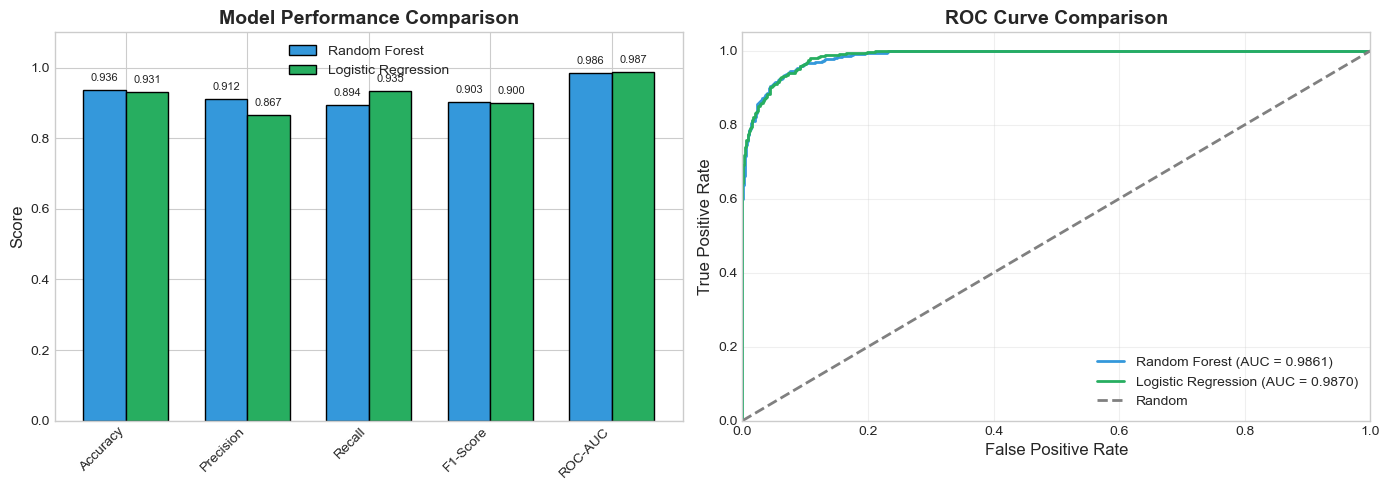

 Plot saved: plots/model_comparison.png


In [27]:
if comparison_available:
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Metric comparison bar chart
    x = np.arange(len(comparison_df['Metric']))
    width = 0.35
    
    bars1 = axes[0].bar(x - width/2, comparison_df['Random Forest'], width, 
                        label='Random Forest', color='#3498db', edgecolor='black')
    bars2 = axes[0].bar(x + width/2, comparison_df['Logistic Regression'], width, 
                        label='Logistic Regression', color='#27ae60', edgecolor='black')
    
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comparison_df['Metric'], rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_ylim([0, 1.1])
    
    # Add value labels
    for bar in bars1:
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)
    
    # ROC curve comparison
    rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred_proba)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_proba)
    
    axes[1].plot(rf_fpr, rf_tpr, color='#3498db', lw=2, 
                 label=f'Random Forest (AUC = {rf_roc_auc:.4f})')
    axes[1].plot(lr_fpr, lr_tpr, color='#27ae60', lw=2, 
                 label=f'Logistic Regression (AUC = {roc_auc:.4f})')
    axes[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
    
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate', fontsize=12)
    axes[1].set_ylabel('True Positive Rate', fontsize=12)
    axes[1].set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(" Plot saved: plots/model_comparison.png")

## 12. Summary

In [28]:
print(f"\n{'='*80}")
print("LOGISTIC REGRESSION MODEL - TRAINING COMPLETE")
print(f"{'='*80}")

print(f"\n Model Performance:")
print(f"   - Accuracy:  {accuracy:.4f}")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall:    {recall:.4f}")
print(f"   - F1-Score:  {f1:.4f}")
print(f"   - ROC-AUC:   {roc_auc:.4f}")

print(f"\n Saved Files:")
print(f"   - models/logistic_regression_model.pkl (sklearn LR model)")
print(f"   - models/scaler_lr.pkl (StandardScaler)")
print(f"   - models/lr_neural_network.keras (Keras model)")
print(f"   - models/logistic_regression_model.tflite (TFLite model)")

print(f"\n Plots:")
print(f"   - plots/lr_confusion_matrix.png")
print(f"   - plots/lr_roc_curve.png")
print(f"   - plots/lr_feature_coefficients.png")
if comparison_available:
    print(f"   - plots/model_comparison.png")

print(f"\n Logistic Regression baseline pipeline complete!")


LOGISTIC REGRESSION MODEL - TRAINING COMPLETE

 Model Performance:
   - Accuracy:  0.9310
   - Precision: 0.8669
   - Recall:    0.9350
   - F1-Score:  0.8997
   - ROC-AUC:   0.9870

 Saved Files:
   - models/logistic_regression_model.pkl (sklearn LR model)
   - models/scaler_lr.pkl (StandardScaler)
   - models/lr_neural_network.keras (Keras model)
   - models/logistic_regression_model.tflite (TFLite model)

 Plots:
   - plots/lr_confusion_matrix.png
   - plots/lr_roc_curve.png
   - plots/lr_feature_coefficients.png
   - plots/model_comparison.png

 Logistic Regression baseline pipeline complete!


---

## Final Notes

### Key Takeaways:
1. **Logistic Regression** serves as a strong baseline model
2. **Feature scaling** is mandatory for Logistic Regression
3. Both models are now available in **.pkl** and **.tflite** formats
4. TFLite models are optimized for mobile deployment

### Risk Score Generation:
```python
risk_score = model.predict_proba(X_new)[:, 1]
```

### Mobile Deployment:
- Use `logistic_regression_model.tflite` for Logistic Regression
- Use `random_forest_model.tflite` for Random Forest (via Neural Network)
- Don't forget to apply the same scaling before inference!